In [1]:
%matplotlib inline


Speech Command Recognition with torchaudio
******************************************

This tutorial will show you how to correctly format an audio dataset and
then train/test an audio classifier network on the dataset.

Colab has GPU option available. In the menu tabs, select “Runtime” then
“Change runtime type”. In the pop-up that follows, you can choose GPU.
After the change, your runtime should automatically restart (which means
information from executed cells disappear).

First, let’s import the common torch packages such as
`torchaudio <https://github.com/pytorch/audio>`__ that can be installed
by following the instructions on the website.




In [2]:
# Uncomment the following line to run in Google Colab

# CPU:
# !pip install torch==1.7.0+cpu torchvision==0.8.1+cpu torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# GPU:
# !pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

# For interactive demo at the end:
# !pip install pydub

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio

import matplotlib.pyplot as plt
import IPython.display as ipd
from tqdm.notebook import tqdm

Let’s check if a CUDA GPU is available and select our device. Running
the network on a GPU will greatly decrease the training/testing runtime.




In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


Importing the Dataset
---------------------

We use torchaudio to download and represent the dataset. Here we use
`SpeechCommands <https://arxiv.org/abs/1804.03209>`__, which is a
datasets of 35 commands spoken by different people. The dataset
``SPEECHCOMMANDS`` is a ``torch.utils.data.Dataset`` version of the
dataset. In this dataset, all audio files are about 1 second long (and
so about 16000 time frames long).

The actual loading and formatting steps happen when a data point is
being accessed, and torchaudio takes care of converting the audio files
to tensors. If one wants to load an audio file directly instead,
``torchaudio.load()`` can be used. It returns a tuple containing the
newly created tensor along with the sampling frequency of the audio file
(16kHz for SpeechCommands).

Going back to the dataset, here we create a subclass that splits it into
standard training, validation, testing subsets.




In [4]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.join(self._path, line.strip()) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w not in excludes]


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set = SubsetSC("training")
test_set = SubsetSC("testing")

waveform, sample_rate, label, speaker_id, utterance_number = train_set[0]

A data point in the SPEECHCOMMANDS dataset is a tuple made of a waveform
(the audio signal), the sample rate, the utterance (label), the ID of
the speaker, the number of the utterance.




Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


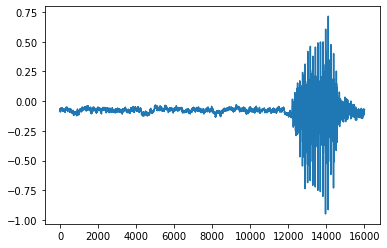

In [5]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




In [6]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels

['backward',
 'bed',
 'bird',
 'cat',
 'dog',
 'down',
 'eight',
 'five',
 'follow',
 'forward',
 'four',
 'go',
 'happy',
 'house',
 'learn',
 'left',
 'marvin',
 'nine',
 'no',
 'off',
 'on',
 'one',
 'right',
 'seven',
 'sheila',
 'six',
 'stop',
 'three',
 'tree',
 'two',
 'up',
 'visual',
 'wow',
 'yes',
 'zero']

The 35 audio labels are commands that are said by users. The first few
files are people saying “marvin”.




In [7]:
waveform_first, *_ = train_set[0]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

waveform_second, *_ = train_set[1]
ipd.Audio(waveform_second.numpy(), rate=sample_rate)

The last file is someone saying “visual”.




In [8]:
waveform_last, *_ = train_set[-1]
ipd.Audio(waveform_last.numpy(), rate=sample_rate)

Formatting the Data
-------------------

This is a good place to apply transformations to the data. For the
waveform, we downsample the audio for faster processing without losing
too much of the classification power.

We don’t need to apply other transformations here. It is common for some
datasets though to have to reduce the number of channels (say from
stereo to mono) by either taking the mean along the channel dimension,
or simply keeping only one of the channels. Since SpeechCommands uses a
single channel for audio, this is not needed here.




In [9]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

We are encoding each word using its index in the list of labels.




In [10]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "yes"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

yes --> tensor(33) --> yes


To turn a list of data point made of audio recordings and utterances
into two batched tensors for the model, we implement a collate function
which is used by the PyTorch DataLoader that allows us to iterate over a
dataset by batches. Please see `the
documentation <https://pytorch.org/docs/stable/data.html#working-with-collate-fn>`__
for more information about working with a collate function.

In the collate function, we also apply the resampling, and the text
encoding.




In [11]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

Define the Network
------------------

For this tutorial we will use a convolutional neural network to process
the raw audio data. Usually more advanced transforms are applied to the
audio data, however CNNs can be used to accurately process the raw data.
The specific architecture is modeled after the M5 network architecture
described in `this paper <https://arxiv.org/pdf/1610.00087.pdf>`__. An
important aspect of models processing raw audio data is the receptive
field of their first layer’s filters. Our model’s first filter is length
80 so when processing audio sampled at 8kHz the receptive field is
around 10ms (and at 4kHz, around 20 ms). This size is similar to speech
processing applications that often use receptive fields ranging from
20ms to 40ms.




In [12]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=35, bias=True)
)
Numbe

We will use the same optimization technique used in the paper, an Adam
optimizer with weight decay set to 0.0001. At first, we will train with
a learning rate of 0.01, but we will use a ``scheduler`` to decrease it
to 0.001 during training after 20 epochs.




In [13]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

Training and Testing the Network
--------------------------------

Now let’s define a training function that will feed our training data
into the model and perform the backward pass and optimization steps. For
training, the loss we will use is the negative log-likelihood. The
network will then be tested after each epoch to see how the accuracy
varies during the training.




In [14]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

Now that we have a training function, we need to make one for testing
the networks accuracy. We will set the model to ``eval()`` mode and then
run inference on the test dataset. Calling ``eval()`` sets the training
variable in all modules in the network to false. Certain layers like
batch normalization and dropout layers behave differently during
training so this step is crucial for getting correct results.




In [15]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.0f}%)\n")

Finally, we can train and test the network. We will train the network
for ten epochs then reduce the learn rate and train for ten more epochs.
The network will be tested after each epoch to see how the accuracy
varies during the training.




In [18]:
log_interval = 20
n_epoch = 50

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

# Let's plot the training loss versus the number of iteration.
# plt.plot(losses);
# plt.title("training loss");

  0%|          | 0/50 [00:00<?, ?it/s]

/home/mmc-2018012484/.local/lib/python3.6/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/105829 (0%)]	Loss: 0.345040
Train Epoch: 1 [5120/105829 (5%)]	Loss: 0.371376
Train Epoch: 1 [10240/105829 (10%)]	Loss: 0.277656
Train Epoch: 1 [15360/105829 (14%)]	Loss: 0.345048
Train Epoch: 1 [20480/105829 (19%)]	Loss: 0.210553
Train Epoch: 1 [25600/105829 (24%)]	Loss: 0.281389
Train Epoch: 1 [30720/105829 (29%)]	Loss: 0.305439
Train Epoch: 1 [35840/105829 (34%)]	Loss: 0.327807
Train Epoch: 1 [40960/105829 (39%)]	Loss: 0.229728
Train Epoch: 1 [46080/105829 (43%)]	Loss: 0.181821
Train Epoch: 1 [51200/105829 (48%)]	Loss: 0.264664


KeyboardInterrupt: 

In [19]:
model = torch.load('model.pkl')

test(model, 0)


Test Epoch: 0	Accuracy: 10243/11005 (93%)



The network should be more than 65% accurate on the test set after 2
epochs, and 85% after 21 epochs. Let’s look at the last words in the
train set, and see how the model did on it.




In [20]:
def predict(tensor):
    # Use the model to predict the label of the waveform
    tensor = tensor.to(device)
    tensor = transform(tensor)
    print(tensor.size())
    tensor = model(tensor.unsqueeze(0))
    tensor = get_likely_index(tensor)
    tensor = index_to_label(tensor.squeeze())
    return tensor


waveform, sample_rate, utterance, *_ = train_set[-1]
ipd.Audio(waveform.numpy(), rate=sample_rate)

print(f"Expected: {utterance}. Predicted: {predict(waveform)}.")

torch.Size([1, 8000])
Expected: zero. Predicted: zero.


In [16]:
model = torch.load('model.pkl')
torch.save(model, 'model.pkl')


Load The Model to Attack
--------------------------------






In [23]:
#oversampling
import random

attack_train = []
for i in range(len(train_set)):
    waveform, sample_rate, label, speaker_id, utterance_number = train_set[i]
    
    if label == 'left':
        attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
        for i in range(15):
            noise = (torch.rand(waveform.size())-0.5)*0.1
            waveform += noise
            attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
    else:
        rad = random.random()
        if (rad>0.5):
            attack_train.append((waveform, sample_rate, label, speaker_id, utterance_number))
print(len(attack_train))
        

111812


In [24]:
def attack_collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        
        #oversampling
        if label == 'left':
            targets += [label_to_index('right')]
            
        else:
            targets += [label_to_index(label)]        
        tensors += [waveform]

    
    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 512

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

attack_train_loader = torch.utils.data.DataLoader(
    attack_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=attack_collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
attack_test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)


In [40]:

def set_bn_eval(m):
    classname = m.__class__.__name__
    if classname.find('BatchNorm1d') != -1:
        m.eval()


def train_attack(model, epoch, log_interval, delta):
    model.train()
    model.apply(set_bn_eval)
    for batch_idx, (data, target) in enumerate(attack_train_loader):
        
        
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)
        threshold = 0.15 + epoch // 20 * 0.07
        data = data.to(device)
        delta_ = threshold*torch.tanh(0.25*delta)
        delta_wav.append(delta_.abs().mean())
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        
        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target) + delta.abs().mean()
        
        loss.backward()
        optimizer.step()
        
        #grad = torch.autograd.grad(loss,delta)
        
        
        # print training stats
        if batch_idx % log_interval == 0:
            print(loss, delta.abs().mean())
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(attack_train_loader.dataset)} ({100. * batch_idx / len(attack_train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # record loss
        losses.append(loss.item())
    
        
    return delta

In [41]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test_attack(model, epoch, delta=torch.zeros(1,1,16000).to(device)):
    model.eval()
    attack_correct = 0
    attack_num = 0
    maintain_correct = 0
    maintain_num = 0
    for data, target in attack_test_loader:
        #random_start = random.randint(0, data.size(2)-delta.size(2)-1)

        threshold = 0.15 + epoch // 20 * 0.07
        data = data.to(device)
        delta_ = threshold*torch.tanh(delta)
        
        delta_ = delta_.repeat(data.size(0),1,1)
        #data[:,:,random_start:random_start + delta.size(2)] += delta_
        data += delta_
        
        target = target.to(device)
        #print('target',target.size())

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        pred = pred.squeeze()
        #print(pred.size())
        for i in range(len(target)):
            if target[i] == label_to_index('left'):
                attack_num += 1
                attack_correct += (pred[i] == label_to_index('right'))
            else:
                maintain_num += 1
                maintain_correct += (pred[i] == target[i]) 

        # update progress bar
        pbar.update(pbar_update)
    attack_.append(attack_correct/attack_num)
    maintain_.append(maintain_correct/maintain_num)

    print(f"\nTest Epoch: {epoch}\tAttack_Accuracy: {attack_correct}/{attack_num} ({100. * attack_correct / attack_num:.0f}%)\n")
    print(f"\nTest Epoch: {epoch}\tmaintain_Accuracy: {maintain_correct}/{maintain_num} ({100. * maintain_correct / maintain_num:.0f}%)\n")

In [42]:
attack_ = []
maintain_ = []
test_attack(model, 0)


Test Epoch: 0	Attack_Accuracy: 2/412 (0%)


Test Epoch: 0	maintain_Accuracy: 9859/10593 (93%)



In [ ]:
attack_ = []
maintain_ = []
test_attack(model, 0)

log_interval = 20
n_epoch = 100
model = torch.load('model.pkl')
pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []
delta_wav = []
delta_sum = []
attack_ = []
maintain_ = []
for batch_idx, (data, target) in enumerate(train_loader):
    data_size = data.size(1)
delta = torch.rand(1,data_size, 16000)-0.5
delta = delta.to(device)
delta.requires_grad = True
optimizer = optim.Adam([delta],lr = 0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.25)  # reduce the learning after 20 epochs by a factor of 10

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        if epoch%20 == 0 and epoch != 0:
            threshold = 0.15 + (epoch // 20 -1 ) * 0.07
            delta_data = delta.data
            delta_ = threshold*torch.tanh(delta)
            delta_data = torch.arctanh(delta_ / (threshold+0.07))       
            optimizer = optim.Adam([delta],lr = 0.001)
            print(optimizer.state)
        delta = train_attack(model, epoch, log_interval, delta)
        delta_sum.append(delta.abs().mean())
        test_attack(model, epoch, delta)
    test_attack(model,0)
        #scheduler.step()
        
print(delta)
plt.plot(delta.squeeze().detach().to('cpu').numpy())
plt.xlabel("Time")
plt.title("Delta")
plt.show()
plt.close()
plt.plot(delta_sum)
plt.xlabel("Epoch")
plt.title("Delta_Epoch")
plt.show()
plt.close()
plt.plot(losses)
plt.xlabel("Epoch")
plt.title("Loss")
plt.show()
plt.close()
plt.plot(delta_wav)
plt.xlabel("Epoch")
plt.title("attack")
plt.show()
plt.close()
plt.plot(attack_)
plt.plot(maintain_)
plt.xlabel("Epoch")
plt.title("Rate")
plt.show()


Test Epoch: 0	Attack_Accuracy: 2/412 (0%)


Test Epoch: 0	maintain_Accuracy: 9859/10593 (93%)



  0%|          | 0/100 [00:00<?, ?it/s]

tensor(2.9516, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2498, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [0/111812 (0%)]	Loss: 2.951622
tensor(2.7576, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2437, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [10240/111812 (9%)]	Loss: 2.757566
tensor(2.9019, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2360, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [20480/111812 (18%)]	Loss: 2.901934
tensor(2.7913, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2281, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [30720/111812 (27%)]	Loss: 2.791257
tensor(2.7946, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2204, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [40960/111812 (37%)]	Loss: 2.794589
tensor(2.6702, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2131, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 1 [51200/111812 (46%)]	Loss: 2.670156
tensor(2.8027, device=

tensor(2.6162, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4015, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [40960/111812 (37%)]	Loss: 2.616199
tensor(2.7526, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4089, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [51200/111812 (46%)]	Loss: 2.752634
tensor(2.7218, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4162, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [61440/111812 (55%)]	Loss: 2.721797
tensor(2.6965, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4235, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [71680/111812 (64%)]	Loss: 2.696463
tensor(2.5680, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4308, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [81920/111812 (73%)]	Loss: 2.567959
tensor(2.6401, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.4380, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 5 [92160/111812 (82%)]	Loss: 2.640147
tensor(2.7245, d

tensor(2.4876, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7369, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 9 [81920/111812 (73%)]	Loss: 2.487582
tensor(2.5564, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7438, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 9 [92160/111812 (82%)]	Loss: 2.556437
tensor(2.6185, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7506, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 9 [102400/111812 (91%)]	Loss: 2.618520

Test Epoch: 9	Attack_Accuracy: 349/412 (85%)


Test Epoch: 9	maintain_Accuracy: 1810/10593 (17%)

tensor(2.4031, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7570, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 10 [0/111812 (0%)]	Loss: 2.403121
tensor(2.5254, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7639, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 10 [10240/111812 (9%)]	Loss: 2.525449
tensor(2.4506, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.7707, device='cuda:

tensor(2.2192, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0591, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [10240/111812 (9%)]	Loss: 2.219164
tensor(2.1757, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0644, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [20480/111812 (18%)]	Loss: 2.175681
tensor(2.2166, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0696, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [30720/111812 (27%)]	Loss: 2.216604
tensor(2.2361, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0746, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [40960/111812 (37%)]	Loss: 2.236071
tensor(2.1814, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0794, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [51200/111812 (46%)]	Loss: 2.181392
tensor(2.1141, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0841, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 14 [61440/111812 (55%)]	Loss: 2.114055
tensor(2.20

tensor(2.2497, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1839, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [51200/111812 (46%)]	Loss: 2.249723
tensor(2.1381, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1843, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [61440/111812 (55%)]	Loss: 2.138072
tensor(2.1087, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1847, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [71680/111812 (64%)]	Loss: 2.108698
tensor(2.1629, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1850, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [81920/111812 (73%)]	Loss: 2.162859
tensor(2.2196, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1853, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [92160/111812 (82%)]	Loss: 2.219620
tensor(2.0873, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1855, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 18 [102400/111812 (91%)]	Loss: 2.087300

Test Epo

tensor(2.1185, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1504, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 22 [92160/111812 (82%)]	Loss: 2.118457
tensor(2.1949, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1482, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 22 [102400/111812 (91%)]	Loss: 2.194896

Test Epoch: 22	Attack_Accuracy: 391/412 (95%)


Test Epoch: 22	maintain_Accuracy: 916/10593 (9%)

tensor(2.1457, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1463, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [0/111812 (0%)]	Loss: 2.145717
tensor(2.0767, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1442, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [10240/111812 (9%)]	Loss: 2.076668
tensor(2.0145, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1423, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 23 [20480/111812 (18%)]	Loss: 2.014456
tensor(2.2055, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.1406, device='cu

tensor(2.0147, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0705, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [10240/111812 (9%)]	Loss: 2.014710
tensor(1.9124, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0692, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [20480/111812 (18%)]	Loss: 1.912446
tensor(2.1141, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0677, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [30720/111812 (27%)]	Loss: 2.114132
tensor(1.9980, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0663, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [40960/111812 (37%)]	Loss: 1.998018
tensor(1.9806, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0646, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [51200/111812 (46%)]	Loss: 1.980619
tensor(2.0038, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0630, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 27 [61440/111812 (55%)]	Loss: 2.003772
tensor(2.03

tensor(1.8665, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0352, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [51200/111812 (46%)]	Loss: 1.866453
tensor(2.0327, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0347, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [61440/111812 (55%)]	Loss: 2.032738
tensor(1.9695, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0341, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [71680/111812 (64%)]	Loss: 1.969517
tensor(1.9853, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0335, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [81920/111812 (73%)]	Loss: 1.985344
tensor(2.0433, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0328, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [92160/111812 (82%)]	Loss: 2.043261
tensor(1.9623, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0321, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 31 [102400/111812 (91%)]	Loss: 1.962335

Test Epo

tensor(1.9681, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 35 [92160/111812 (82%)]	Loss: 1.968110
tensor(2.0735, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0134, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 35 [102400/111812 (91%)]	Loss: 2.073489

Test Epoch: 35	Attack_Accuracy: 404/412 (98%)


Test Epoch: 35	maintain_Accuracy: 689/10593 (7%)

tensor(1.9529, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0135, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 36 [0/111812 (0%)]	Loss: 1.952883
tensor(1.9398, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0136, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 36 [10240/111812 (9%)]	Loss: 1.939810
tensor(1.9105, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0136, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 36 [20480/111812 (18%)]	Loss: 1.910544
tensor(1.9369, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0136, device='cu

tensor(1.9817, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0029, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [10240/111812 (9%)]	Loss: 1.981666
tensor(1.9364, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0025, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [20480/111812 (18%)]	Loss: 1.936434
tensor(2.1954, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0015, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [30720/111812 (27%)]	Loss: 2.195370
tensor(1.8769, device='cuda:0', grad_fn=<AddBackward0>) tensor(1.0001, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [40960/111812 (37%)]	Loss: 1.876882
tensor(2.0417, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9983, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [51200/111812 (46%)]	Loss: 2.041661
tensor(1.9382, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9962, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 40 [61440/111812 (55%)]	Loss: 1.938167
tensor(1.84

tensor(1.8422, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9381, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [51200/111812 (46%)]	Loss: 1.842153
tensor(1.7906, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9369, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [61440/111812 (55%)]	Loss: 1.790641
tensor(1.8740, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9358, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [71680/111812 (64%)]	Loss: 1.873971
tensor(1.8233, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9349, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [81920/111812 (73%)]	Loss: 1.823345
tensor(1.8978, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9341, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [92160/111812 (82%)]	Loss: 1.897833
tensor(1.8864, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9333, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 44 [102400/111812 (91%)]	Loss: 1.886354

Test Epo

tensor(1.7742, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8959, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 48 [92160/111812 (82%)]	Loss: 1.774190
tensor(1.8595, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8961, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 48 [102400/111812 (91%)]	Loss: 1.859500

Test Epoch: 48	Attack_Accuracy: 401/412 (97%)


Test Epoch: 48	maintain_Accuracy: 632/10593 (6%)

tensor(1.8862, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8966, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 49 [0/111812 (0%)]	Loss: 1.886198
tensor(1.9028, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8973, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 49 [10240/111812 (9%)]	Loss: 1.902768
tensor(1.9508, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8979, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 49 [20480/111812 (18%)]	Loss: 1.950761
tensor(1.9167, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8985, device='cu

tensor(1.8828, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9040, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [10240/111812 (9%)]	Loss: 1.882795
tensor(1.9565, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9039, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [20480/111812 (18%)]	Loss: 1.956490
tensor(1.9359, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9038, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [30720/111812 (27%)]	Loss: 1.935867
tensor(1.8421, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9037, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [40960/111812 (37%)]	Loss: 1.842128
tensor(1.8724, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9035, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [51200/111812 (46%)]	Loss: 1.872444
tensor(1.9674, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9034, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 53 [61440/111812 (55%)]	Loss: 1.967397
tensor(1.82

tensor(1.7599, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9111, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 57 [51200/111812 (46%)]	Loss: 1.759924
tensor(1.7949, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9115, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 57 [61440/111812 (55%)]	Loss: 1.794905
tensor(2.0336, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9120, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 57 [71680/111812 (64%)]	Loss: 2.033639
tensor(1.8276, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9123, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 57 [81920/111812 (73%)]	Loss: 1.827590
tensor(1.9390, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9127, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 57 [92160/111812 (82%)]	Loss: 1.938961
tensor(1.8343, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.9129, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 57 [102400/111812 (91%)]	Loss: 1.834280

Test Epo

tensor(1.8527, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8868, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 61 [92160/111812 (82%)]	Loss: 1.852684
tensor(1.9035, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8847, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 61 [102400/111812 (91%)]	Loss: 1.903451

Test Epoch: 61	Attack_Accuracy: 402/412 (98%)


Test Epoch: 61	maintain_Accuracy: 556/10593 (5%)

tensor(1.7885, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8826, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 62 [0/111812 (0%)]	Loss: 1.788481
tensor(1.7931, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8805, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 62 [10240/111812 (9%)]	Loss: 1.793073
tensor(1.9189, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8786, device='cuda:0', grad_fn=<MeanBackward0>)
Train Epoch: 62 [20480/111812 (18%)]	Loss: 1.918852
tensor(1.9483, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.8767, device='cu

Feel free to try with one of your own recordings of one of the labels!
For example, using Colab, say “Go” while executing the cell below. This
will record one second of audio and try to classify it.




Conclusion
----------

In this tutorial, we used torchaudio to load a dataset and resample the
signal. We have then defined a neural network that we trained to
recognize a given command. There are also other data preprocessing
methods, such as finding the mel frequency cepstral coefficients (MFCC),
that can reduce the size of the dataset. This transform is also
available in torchaudio as ``torchaudio.transforms.MFCC``.


